In [1]:
import kagome, qiskit, qiskit.tools.jupyter
import numpy as np, matplotlib.pyplot as plt
from importlib import reload

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)
%qiskit_version_table

import jTools
jTools.cellOutputAll()

Start at Fri Mar 10 20:00:20 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [45]:
def runJob(Hkey=None,Akey=None,miniAkey=None,nshots=1024,optimization=3,resilience=1,
           pt_idx='Random',backend=None, Okey=None, numRuns=-1, service=None, x0=None, fname=None,
           forced_xdata = None,
           job_tags=['runJob']):
    from qiskit_aer.backends.aerbackend import AerBackend, AerError
    from qiskit_ibm_runtime import Options
    if backend is None or isinstance(backend,AerBackend):
        service = None
        options = { 'shots': nshots }
    else:
        service = service
        options = Options(optimization_level = optimization, 
                          resilience_level  = resilience,
                          execution = {'shots':nshots}, 
                          environment = {'job_tags':job_tags},
                         )   

    #==================== Job Control ======================
    label = (f"{backend}['shots':{nshots} 'Optimize':{optimization} 'Resilience':{resilience}]\n"
             f"H:{Hkey} A:{Anzs[Akey].name}\nOpt:{optimizers[Okey]['label']} x0={pt_idx}")
    if numRuns > 0:
        curCache = kagome.load_results(fname)
        for i in range(numRuns):
            print(f"Starting Run {i}")
            custom_vqe = kagome.run_kagomeVQE(hams[Hkey], Anzs[Akey], optimizers[Okey]['opt'], 
                                         miniAnsatz=Anzs[miniAkey],
                                         timeout=None, x0=x0, 
                                         target=np.around(targets[Hkey],6),
                                         service=service, backend=backend,
                                         resultsList=curCache, 
                                         label=label, options=options,
                                         forced_xdata=forced_xdata,)
            kagome.save_results(curCache,fname)
        return curCache
    else:
        print(label)
        
        
def runConfig(orgConfig,updates=None,plot=False,global_seed=None, np_seed=None):
    from qiskit.utils import algorithm_globals
    updates = {} if updates is None else updates
    finalConfig = {key: updates.get(key, orgConfig[key]) for key in orgConfig}
    if np_seed is not None:
        np.random.seed(np_seed)
    if global_seed is not None:
        algorithm_globals.random_seed = global_seed   # For SPSA stochastic repeatability
    curCache = runJob(**finalConfig)
    if plot and finalConfig.get('forced_xdata',None) is None:
        kagome.plot_SPSA_convergence(curCache,indices=[-1],conv_lim = 0.03,movingAvg=5,
                                     perc=6,convergence=False,minStart=20)
    return curCache


In [3]:
def compare_forcedX(indices,label_dict=None,labels=['0','1'],title=None,fdata=[],xdata=[]):
    xdiffNorms,fdiffNorms =[],[]
    
    labels=[label_dict[indices[0]],label_dict[indices[1]]] if label_dict is not None else labels
    title=f"{labels[0]}({labels[1]})" if title is None else title
    colors=['red','green']
    
    for idx in indices:
        fdata.append(curCache[idx]._callback_data)
        xdata.append(curCache[idx]._callback_points)
    xdiffs = np.array(xdata[0]) -  np.array(xdata[1])

    delXnorms  = np.linalg.norm(xdiffs,axis=1)
    for curDiff in xdiffs:
        xdiffNorms.append(np.linalg.norm(curDiff))
    fdiffs = np.array(fdata[0]) -  np.array(fdata[1])
    for curDiff in fdiffs:
        fdiffNorms.append(np.linalg.norm(curDiff))

    maxdelX = np.max(delXnorms)
    if maxdelX < 0.001:
        print(f"Identical X max(delX)={maxdelX}")
    kagome.quick_plot(fdata,labels=labels,colors=colors,figsize=(8.5,6), title=title)
    kagome.quick_plot(fdiffNorms,labels=[f"Delta F(x)[{labels[0]}][{labels[1]}]"],title=f'delF {labels[0]}')

    if maxdelX >= 0.001:
        kagome.quick_plot(delXnorms,labels=['||del; X||'],title='||Norm delX||')

def compare_runs(dataCache,indices=None,labels=('Unk','Unk')):
    (idxA,idxB) = (indices[0],indices[1])
    (devA,devB) = (labels[0],labels[1])
    xdata=[ dataCache[idxA]._callback_points, dataCache[idxB]._callback_points ]
    fdata=[ dataCache[idxA]._callback_data,   dataCache[idxB]._callback_data ]
    (minA,minB) = (np.min(np.array(fdata[0])),np.min(np.array(fdata[1])))
    (minAidx,minBidx) = (np.argmin(np.array(fdata[0])),np.argmin(np.array(fdata[1])))
    print(f"Minimums\n\tFa[{minAidx}]={minA:6.4f}\n\tFb[{minBidx}]={minB:6.4f}\n")
    
    compare_forcedX([],label_dict=None,labels=[f'{devA}[{idxA}]',f'{devB}[{idxB}]'],
                    xdata=xdata,fdata=fdata, title=f'{devB}[{devA}({idxA})]') 
    kagome.plot_SPSA_convergence(dataCache,indices=[idxB],convergence=False,)


# Hamiltonians and Ansatze

In [4]:
import kagome, hamiltonians, ansatze

optimizers=kagome.init_optimizers()  #=================== Optimizers =========================#

cells = hamiltonians.init_cells()    #===================  Cell Structures ===================#
positions = hamiltonians.init_positions()
#====================  Hamiltonians =====================#
hams,eigenvalue_results,targets = hamiltonians.init_hamiltonians(cells=cells,force=False, k=128,
                                                                 display=3)
print(f"Hamiltonians Loaded")
#=======================  Ansatze =======================#
# Anzs = ansatze.init_ansatze(H=hams,backends=backends,targets=targets)



H12_16: Edges 18 Eigenvalues 128 
	-18.0000:[32]
	-16.9613:[48]
	-16.9449:[48]

H4_7: Edges 4 Eigenvalues 128 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]

H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]

H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]

Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]

Hsq_7: Edges 4 Eigenvalues 128 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[56]

H4_12: Edges 4 Eigenvalues 128 
	 -6.0000:[88]
	 -4.0000:[40]

H4_4_BC1: Edges 4 Eigenvalues 16 
	 -6.0000:[5]
	 -2.0000:[3]
	  2.0000:[3]

H4_7_BC1: Edges 4 Eigenvalues 128 
	 -6.0000:[40]
	 -2.0000:[24]
	  2.0000:[24]

H4_12_BC1: Edges 4 Eigenvalues 128 
	 -6.0000:[81]
	 -2.0000:[47]

H5_5: Edges 6 Eigenvalues 32 
	 -6.0000:[6]
	 -4.0000:[4]
	 -2.0000:[2]

H5_7: Edges 6 Eigenvalues 128 
	 -6.0000:[24]
	 -4.0000:[16]
	 -2.0000:[8]

H5_16: Edges 6 Eigenvalues 128 
	 -6.0000:[58]
	 -4.0000:[55]
	 -2.0000:[15]

H3_5: Edges 3 Eigenvalues 32 
	 -3.0000:[16]
	

In [11]:
# Setup Account, Provider, Service and Backends
( provider, service, backends, simulators, backendsV0, backends_runtime) = kagome.setup_devices(max_parallel=3)

<module 'kagome' from '/home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022/kagome.py'>

Available backends
	ibmq_qasm_simulator
	ibmq_lima
	ibmq_belem
	ibmq_quito
	simulator_statevector
	simulator_mps
	simulator_extended_stabilizer
	simulator_stabilizer
	ibmq_jakarta
	ibmq_manila
	ibm_lagos
	ibm_nairobi
	ibm_perth
	ibm_oslo
Available backends
	ibmq_belem
	simulator_mps
	ibm_perth
	ibmq_manila
	ibm_oslo
	ibm_nairobi
	simulator_stabilizer
	ibmq_jakarta
	ibmq_qasm_simulator
	ibmq_quito
	ibmq_lima
	simulator_extended_stabilizer
	simulator_statevector
	ibm_lagos
Hardware Setup Complete


PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

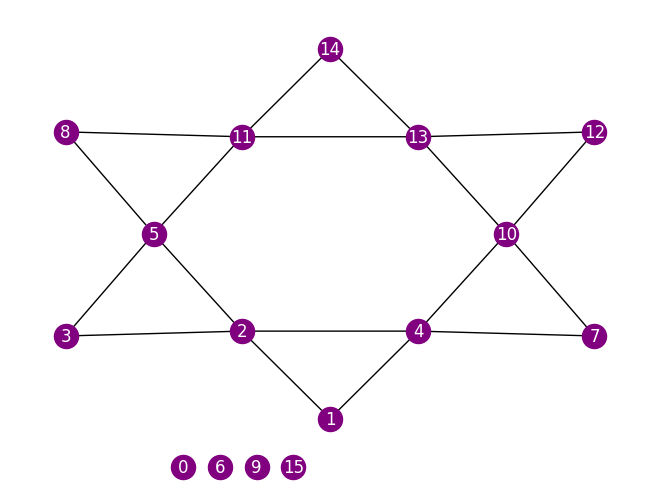

In [6]:
key='12_16'
_=kagome.draw_lattice(cells[key],positions[key])
hams[key]

# Optimizer Options

In [79]:
from qiskit.circuit.library import EfficientSU2
from qiskit import transpile
qbits12 = [1,2,3,4,5,7,8,10,11,12,13,14,]
E1 = [ [1,2],[5,3],[14,13],[10,12], [1,4],[5,8],[14,11],[10,7] ]                            # Outer - Linked
E2 = [ [2,3],[8,11],[12,13],[4,7] ]                                                         # Outer - Missing
E3 = [ [1,2],[5,3],[14,13],[10,12], [1,4],[5,8],[14,11],[10,7], [2,3],[8,11],[12,13],[4,7]] # All Outer/Coupled
E4 = [ [12,10],[10,12],(4,7),(7,4), (1,2),(2,1), [8,11],[11,8], [14,13],[13,14], ]          # Bit Swaps
E5 = [ [2,4],[13,10], [2,5], [13,11], [5,11], [10,4] ]                                      # Non-Coupled
E6 = [ [1,2],[5,3],[14,13],[10,12], ]
E7 = [ [1,4],[5,8],[14,11],[10,7] ]
E8 = [ [1,2],[2,3],[3,5],[5,8],[8,11],[11,14],[14,13],[13,12],[12,10],[10,7],[7,4],[4,1] ]  # Coupled - Up
E9 = [ [1,4],[4,7],[7,10],[10,12],[12,13],[13,14],[14,11],[11,8],[8,5],[5,3],[3,2],[2,1] ]   # Coupled - Down

E10= [ [1,2],[2,3],[3,5],[5,8],[8,11],[11,14], ]  # Coupled - Up
E11= [ [14,13],[13,12],[12,10],[10,7],[7,4],[4,1] ]  # Coupled - Up
A12_16stacks = {
#                 'STC0': [ E1, E2 ], 'STC1': [ E3, E5 ], 'STC2': [ E3, E4 ],
#                 'STC3': [ E1, E2, E4 ],
#                 'STC4': [ E1, E2, E5 ], 'STC5': [ E4, E2, E1 ],
#                 'STC6': [ E6, E7, E2, E4 ],
#                 'STC7': [ E6, E5, E7, E4],
#                 'STC8': [ E8, E9 ],
#                 'STC9': [ E8, E5, E9 ],
#                 'ST10': [ E10, E5, E11, E4],
                'ST11': [ E8, E4, E9 ],
               }
print(f"Building Stacked Ansatze")


Anzs,Adevices=ansatze.stack_couplings(Anzs=None, qubits=qbits12, Adevices=None, backends=backendsV0,   
                                      couplings=A12_16stacks, nNodes=12, nQubits=16, qbitmap=list(range(16)),
                                      devices=['g'], )
#=========  Setup a test Ansazt 
Anzs['A12_16_SU2_L1'] = EfficientSU2(12, entanglement='linear', reps=2,
                             name='A12_16_SU2_L1',skip_final_rotation_layer=True).decompose()
Anzs['A12_g_SU2_L1'] = transpile(Anzs['A12_16_SU2_L1'], backend=backends['g'], 
                                 initial_layout=ansatze.qbitmap_12_to_16)
Anzs['A12_g_SU2_L1'].name = 'A12_g_SU2_L1'
Adevices['A12_g_SU2_L1'] = 'g'
#=====================  Compatible backends for pulse scheduling =======================
AbackendsV0={}
for key, D in Adevices.items():
    AbackendsV0[key] = backendsV0[D]

print(f"Building Circuit Images")
Aimages=ansatze.Anzs_images( Akeys=None, Anzs=Anzs )
print(f"Building Circuit Schedules")
schedules,sched_images=ansatze.Anzs_schedules(Akeys=None, Anzs=Anzs, backends=AbackendsV0,)
print(f"\nSchedules Complete")

Building Stacked Ansatze
Building Circuit Images
Building Circuit Schedules
No Backend  A12_16_ST11_L1, A12_16_SU2_L1,
Schedules Complete


In [80]:
evalKeys = ['A12_g_STC0_L1','A12_g_STC1_L1','A12_g_STC2_L1','A12_g_STC3_L1','A12_g_STC4_L1']
df = ansatze.eval_schedules(schedules, AbackendsV0,Akeys=None, qubits=qbits12)
df

Anzs,MeasErr%,T1-Decay,T2-Decay,Parms,t (ns),T1(us),T2(us),t/T1,t/T2
A12_g_ST11_L1,6.05,76.21,83.74,72,"10,567.11",38.89,59.54,0.2717,0.1775
A12_g_SU2_L1,6.05,86.49,90.95,48,"5,646.22",38.89,59.54,0.1452,0.0948


A12_g_STC0_L1, 2 layers, 48 parameters


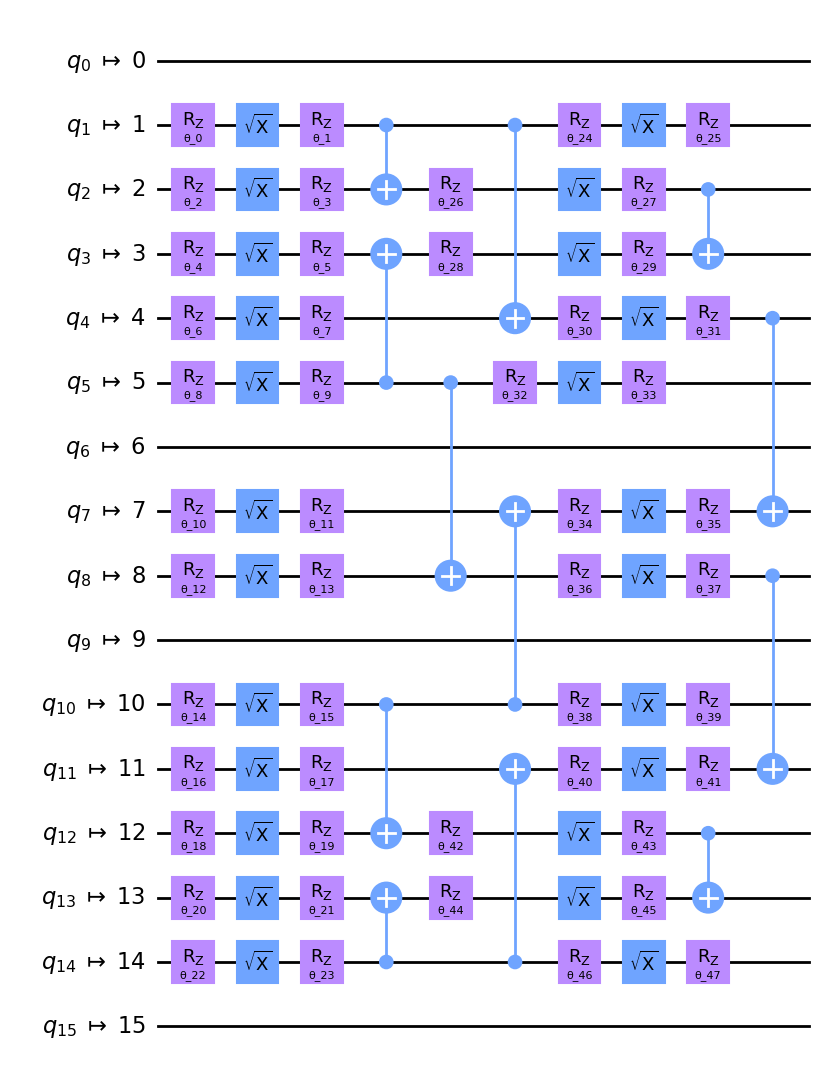

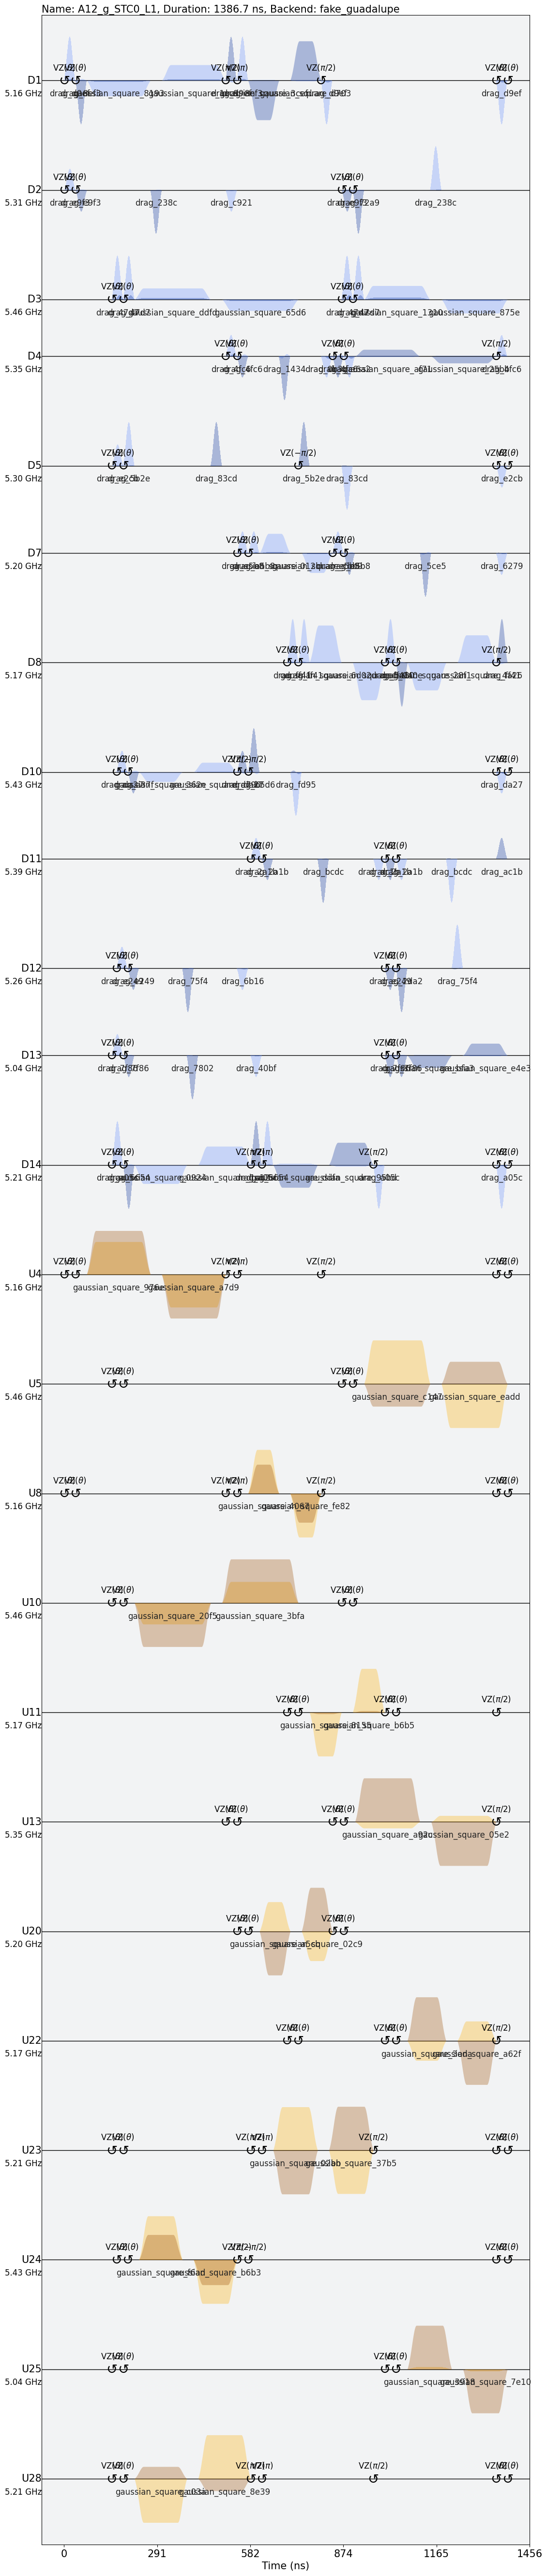

In [36]:
key='A12_g_STC0_L1'
print(f"{key}, {int(Anzs[key].num_parameters/24)} layers, {Anzs[key].num_parameters} parameters")
Anzs[key].draw()
sched_images[key]

In [73]:
run_fname='data/H12_16.dump'
curCache = kagome.load_results(run_fname)
# kagome.list_results(curCache)

# comp_fname='data/H5_7_comp.dump'
# compCache = kagome.load_results(comp_fname)
# kagome.list_results(compCache)
print("============== Reloaded Data =====================")

Loaded 27 results from data/H12_16.dump
============== Reloaded Data =====================


In [81]:
#================= Problem Setup =====================
fname=run_fname   # run_fname, comp_fname
pt_idx = 'Random'        # '0'-> 0 vector; [int] -> point cache; else -> Random
if isinstance(pt_idx,int) and len(curCache) <= pt_idx:
    curCache = kagome.load_results(fname)
x0, expVal =  kagome.getX0(pt_idx,curCache)
for E,R in [ ('SU2',1) ]:
        runconfig = {'Hkey'         : '12_16', 'fname' : fname,
                     'Akey'         : f'A12_16_{E}_L{R}', 'miniAkey' : f'A12_16_{E}_L{R}',
                     'Okey'         : '13',         # 00->10 02->75 04->150 06->300 13->350 14->200 15->100
                     'nshots'       : 2048, 'optimization' : 3, 'resilience'   : 1,
                     'backend'      : None, 'service' : None,  'numRuns' : 1, 
                     'forced_xdata' : None, 'x0' : x0,'pt_idx': pt_idx, }
        job_tags = {'H':f"H{runconfig['Hkey']}",'A':runconfig['Akey'], 'S':f"shots({runconfig['nshots']})",
                    'O':f"Opt({runconfig['optimization']}", 'R':f"Res({runconfig['resilience']}", }
        updates={'job_tags' : list(job_tags.values())}
        # runconfig['forced_xdata'] = curCache[1]._callback_points
        ############  Initial Configuration Run, None, None  ####################
        CurCache = runConfig(runconfig, plot=True, global_seed=177801, np_seed=177801, updates=updates )

        # runconfig['forced_xdata'] = curCache[200]._callback_points
#         for D in ['g',]:  # Devices lagos,jakarta,perth,oslo  # Manila is different mapping
#             job_tags['A'] = f'A12_{D}_{E}_L{R}'
#             updates={'service' : None, 'Akey': job_tags['A'], 'job_tags': list(job_tags.values()),}
#             if updates.get('service', runconfig.get('service',None)) is None:
#                 updates['backend'] = simulators[D]
#             else:
#                 updates['backend'] = backends_runtime[D]
#             CurCache = runConfig(runconfig, plot=True, global_seed=177801, np_seed=177801, updates=updates,)
curCache = kagome.load_results(fname)
print(f"\n\t========== Data Runs Complete ============")

Loaded 28 results from data/H12_16.dump
Starting Run 0
None['shots':2048 'Optimize':3 'Resilience':1]
H:12_16 A:A12_16_SU2_L1
Opt:SPSA(350,cb) x0=Random idx=28
Exception <class 'ValueError'> 


AttributeError: 'ValueError' object has no attribute 'printStackTrace'

# Saved Images

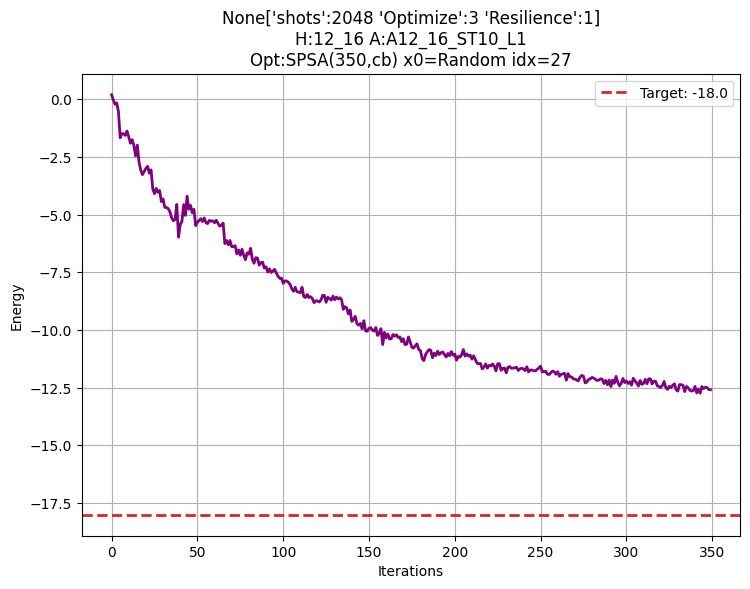

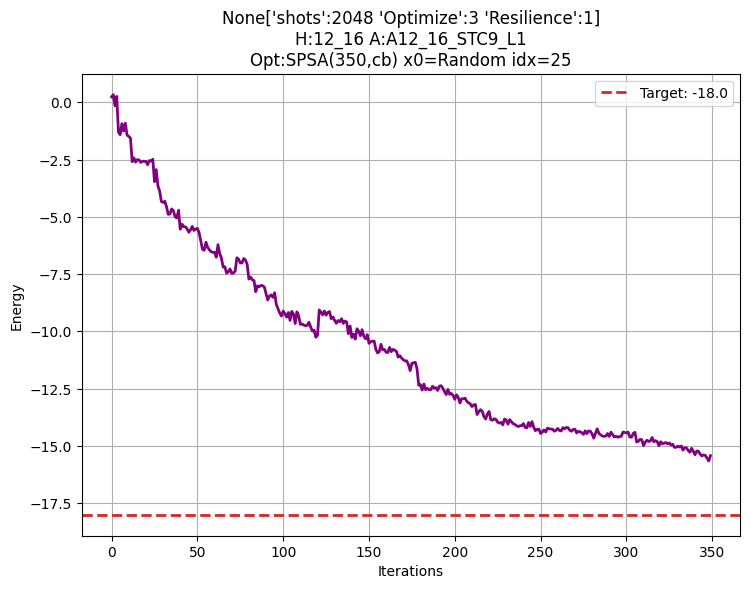

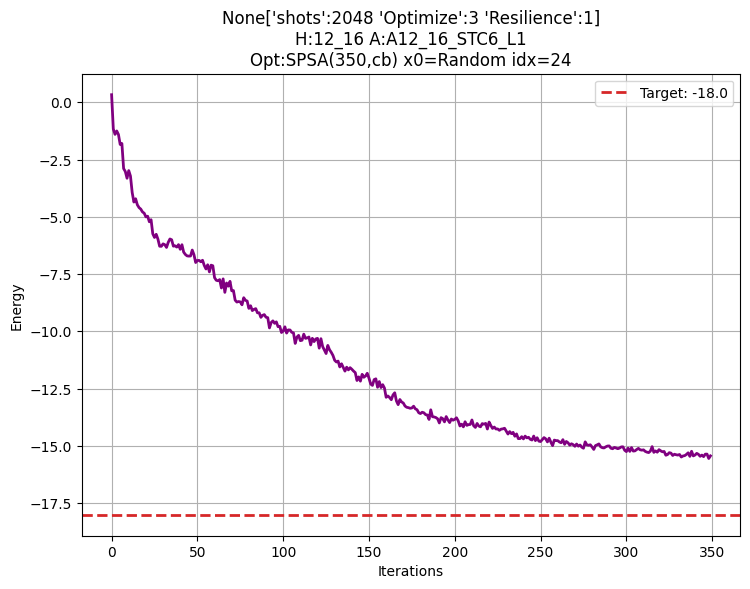

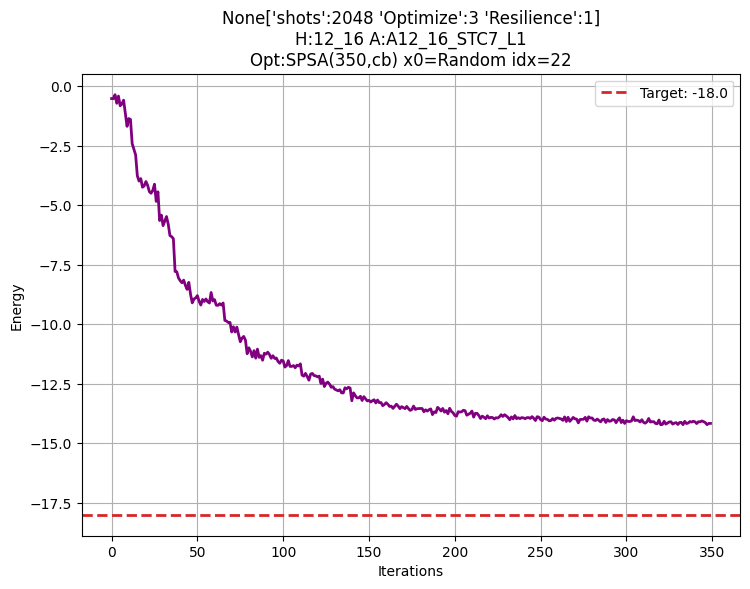

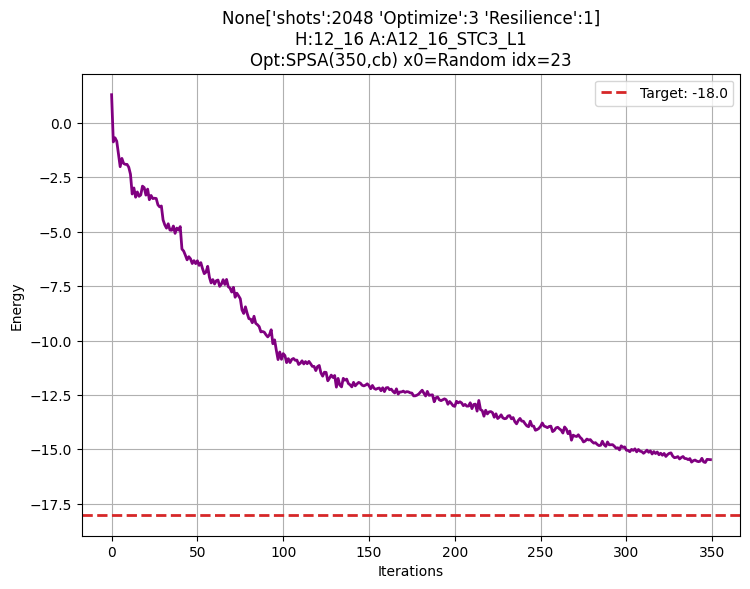

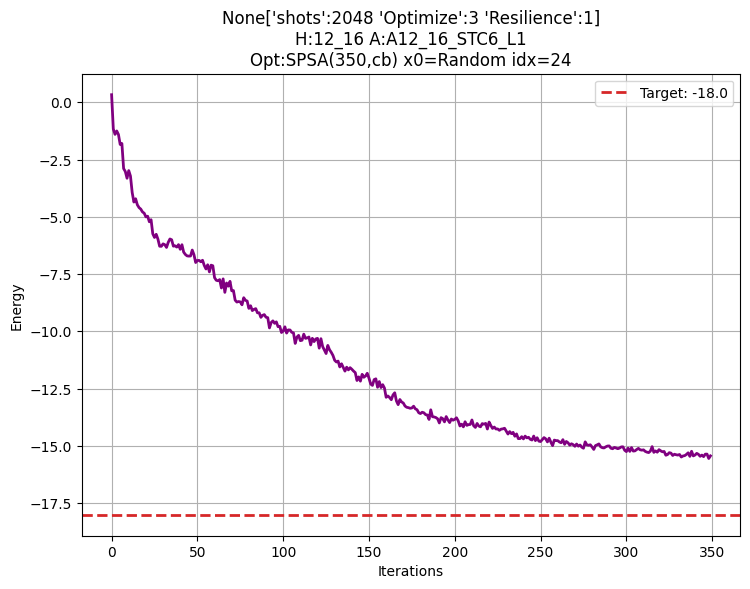

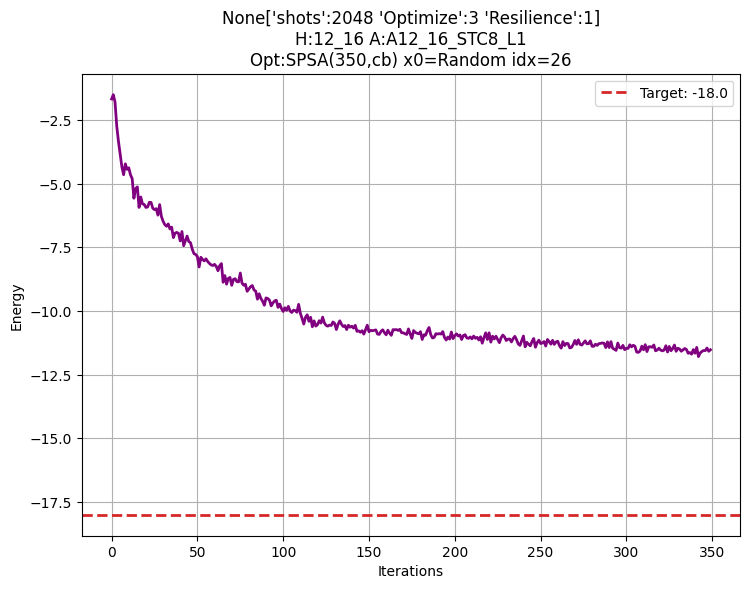

In [ ]:
# kagome.plot_SPSA_convergence(curCache,indices=[44]
# compare_runs(curCache,indices=(47,42),labels=('None','Lagos(ST22)'))
# compare_runs(curCache,indices=(48,44),labels=('None','Jakarta(ST23)'))
# compare_runs(curCache,indices=(49,45),labels=('None','Lagos(ST23)'))

# compare_runs(curCache,indices=(62,54),labels=('None','Perth(ST20)'))
# compare_runs(curCache,indices=(63,55),labels=('None','Oslo(ST20)'))

# compare_runs(curCache,indices=(64,57),labels=('None','Perth(ST22)'))
# compare_runs(curCache,indices=(65,58),labels=('None','Oslo(ST22)'))

# compare_runs(curCache,indices=(66,60),labels=('None','Perth(ST23)'))
# compare_runs(curCache,indices=(67,61),labels=('None','Oslo(ST23)'))



compare_runs(curCache,indices=(2,1),labels=('None','ibm_lagos(ST20)'))
# compare_runs(curCache,indices=(75,71),labels=('None','Lagos(ST22)'))
# compare_runs(curCache,indices=(76,73),labels=('None','Lagos(ST23)'))


In [ ]:
run=261

kagome.plot_SPSA_convergence(curCache,indices=[run],conv_lim = 0.03,movingAvg=5,
                                     perc=6,convergence=False,minStart=20)


spsa_data     = curCache[run].SPSA_callback_data
callback_pts  = curCache[run]._callback_points
callback_data = curCache[run]._callback_data
print(f"callback_pts {len(callback_pts)}  callback_data {len(callback_data)}")
parsed_data = kagome.parse_SPSA_callback(spsa_data)
eval_pts = parsed_data['nF']
eval_data = parsed_data['F']
print(f"eval_pts {len(eval_pts)}  eval_data {len(eval_data)}")
for idx in range(1):
    print(f"cb[{idx}] = {callback_data[idx]}")
    
for idx in range(1):
    print(f"F[{idx}] = {eval_data[idx]} at n:{eval_pts[idx]}")

kagome.quick_plot(callback_data,labels=['cb'],figsize=(8.5,6), title='callback')
kagome.quick_plot(eval_data,labels=['eval'],figsize=(8.5,6), title='eval')



evalPt=1
print(f"Eval {evalPt} at {eval_pts[1]} : {eval_data[1]}")
for idx in range(7):
    print(f"{idx} callback_data {callback_data[idx]}")
# diffData = np.array(fData) - np.array(eval_data)
# diffData

In [ ]:
reload(ansatze)

In [ ]:
################### Compute Edge Results ##################
# importlib.reload(kagome)
(backendA,backendB,backendC)=(None,limaSim, None)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R1',248,250)
(Akey,runIdx, iteration) = ('A3_b_SA4_R2',254,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R3',250,250)
(Hkey, Akey, runIdx, iteration) = ('3_5','A3_a_SA4_R4',251,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R5',252,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R6',253,250)

# (Akey,runIdx, iteration) = ('A3_m_SA6_R2',200,500)

(num_qubits,edges,qbitmap) = (5, hamiltonians.edges_3_5, ansatze.qbitmap_3_to_5,)

Xa = curCache[runIdx]._callback_points[iteration]    # None
H  = hams['edges_3_5' ] = hamiltonians.edge_hamiltonians(edges, num_qubits)
A = [ Anzs[Akey] ]*len(H)
x = [ Xa ]*len(H)
random_seed = np.random.randint(1,999999999)
########## Runtime Setup
(optimization, resilience)=(3,1)
nshots=4096
job_tags=['edges']
print(f"Compare Edges A:{Akey} run:{runIdx} iteration:{iteration} seed:{random_seed} shots:{nshots}"
      f"\nqubits {qbitmap}")
if backendA is None:          ##### None, None #####
    from qiskit.primitives import Estimator
    np.random.seed(random_seed)
    estimator = Estimator(A, H, options={ 'shots': nshots } )
    print(f"resultsA: {backendA}")
    resultsA = kagome.try_estimator( estimator, A, H, x )

if backendB  is not None:     #### AerSimulators ###
    from qiskit.primitives import BackendEstimator
    np.random.seed(random_seed)
    print(f"resultsB: {backendB}")
    backend_estimator = BackendEstimator(backendB, 
                                         skip_transpilation=True,
                                         options={ 'shots': nshots })
    resultsB = kagome.try_estimator(backend_estimator, A, H, x )

if backendC is not None:    ### Backend Estimator
    print(f"Starting Estimator for runtime {backendC}")
    from qiskit_ibm_runtime import Session, Options, Estimator as RuntimeEstimator  
    with Session(service=service, backend=backendC) as session:
        runtime_estimator = RuntimeEstimator(session=session, 
                                     options=Options(optimization_level = optimization, 
                                                     resilience_level  = resilience,
                                                     execution = {'shots':nshots}, 
                                                     environment = {'job_tags': job_tags},
                                                    )
                                    )
        resultsC = kagome.try_estimator(runtime_estimator, A, H, x )

compare_edge_results(resultsA,resultsB,edges,A=Anzs[Akey],x=Xa)
print(f"Edge Calculations Completed")

In [ ]:
################### Sample Distributions ##################
import myTools
myTools.strtime()
# importlib.reload(kagome)
# jobQ=[]
jobList = kagome.load_object('data/jobList.dump')
jobResults = kagome.load_object('data/jobResults.dump')

(waitRuntime,runRotations,runEdges,runExpectations) = (False, False, True, False)
(backendA,backendB,backendC)=(None,limaSim,'ibmq_lima')

# (Akey,runIdx, iteration) = ('A3_m_SA4_R1',248,250)
(Hkey,Akey,runIdx, iteration) = ('3_5','A3_b_SA4_R2',254,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R3',250,250)
(Hkey,Akey,runIdx, iteration) = ('3_5','A3_a_SA4_R4',251,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R5',252,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R6',253,250)
# (Akey,runIdx, iteration) = ('A3_m_SA6_R2',200,500)

############### Full Hamiltonians and Ansazte ###############
(num_qubits,edges,qbitmap) = (5, hamiltonians.edges_3_5, ansatze.qbitmap_3_to_5,)
H  = hamiltonians.edge_hamiltonians(edges, num_qubits)
Xa = curCache[runIdx]._callback_points[iteration]    # None
Aa = Anzs[Akey].copy()
A = Aa.bind_parameters(Xa)
################  Rotated Ansatze ######################
qcZ = A.copy()
qcX = qcZ.copy()
_=qcX.h((0,1,2))
qcY = qcZ.copy()
_=qcY.sdg((0,1,2))
_=qcY.h((0,1,2))
_=qcX.measure_all()
_=qcY.measure_all()
_=qcZ.measure_all()
qcBasis={'X':qcX,'Y':qcY,'Z':qcZ} if runRotations else {}
###################### Runtime Setup ####################
random_seed = np.random.randint(1,999999999)
(optimization, resilience)=(3,3)
nshots=4096
job_tags = {'Type':'Sampler','Backend':'None','Basis':'Z-Measure','Hkey':f"H{Hkey}"}
print(f"Sample Dists A:{Akey} run:{runIdx} iteration:{iteration} seed:{random_seed} shots:{nshots}"
      f"\nqubits {qbitmap}") 
for qcKey, curQC in qcBasis.items():   ### If Run Rotations
    job_tags['Basis']=f"{qcKey}-Measure"
    if backendA is None:          ##### None, None #####
        print(f"Starting Estimator for simulator {backendA}")
        from qiskit.primitives import Sampler
        np.random.seed(random_seed)
        sampler = Sampler(curQC, options={ 'shots': nshots } )
        job_tags['Backend']='None'
        jobA=sampler.run(qc, options={'shots':nshots, 'job_tags':  list(job_tags.values())}, )
        jobList[jobA.job_id()] = f"{type(jobA).__name__},None,{job_tags['Basis']}"
        resultsA = jobA.result()
        jobResults[jobA.job_id()] = resultsA

    if backendB  is not None:     #### AerSimulators ###
        print(f"Starting Estimator for simulator {backendB}")
        from qiskit.primitives import BackendSampler
        np.random.seed(random_seed)
        job_tags['Backend']=f'{backendB}'
        sampler = BackendSampler(backendB,skip_transpilation=True,options={ 'shots': nshots })
        jobB = sampler.run(curQC,options={'shots':nshots}) 
        jobList[jobB.job_id()] = f"{type(jobB).__name__},{backendB},{job_tags['Basis']}"
        resultsB = jobB.result()
        jobResults[jobB.job_id()] = resultsB

    if backendC is not None:    ### Backend Estimator
        print(f"Starting Estimator for runtime {backendC}")
        from qiskit_ibm_runtime import (Session, Options, Estimator as RuntimeEstimator , 
                                        Sampler as RuntimeSampler )
        job_tags['Backend']=f'{backendC}'
        with Session(service=service, backend=backendC) as session:
            sampler = RuntimeSampler(session=session, 
                                         options=Options(optimization_level = optimization, 
                                                         resilience_level  = resilience,
                                                         execution = {'shots':nshots}, 
                                                         environment = {'job_tags': list(job_tags.values())},
                                                        )
                                        )
            jobC = sampler.run(curQC)
            jobQ.append(jobC)
            jobList[jobC.job_id()] = f"{type(jobC).__name__},{backendC},{job_tags['Basis']}"
            if waitRuntime:
                resultsC = jobC.result()
                jobResults[jobC.job_id()] = resultsC  
    kagome.save_object(jobList,   'data/jobList.dump')
    kagome.save_object(jobResults,'data/jobResults.dump')

if runEdges:
    job_tags['Type'] = 'Edges'
    if backendA is None:          ##### None, None #####    
        print(f"Starting Estimator for runtime {backendA}")
        from qiskit.primitives import Estimator
        np.random.seed(random_seed)
        estimator = Estimator(A, H, options={ 'shots': nshots } )
        _job = estimator.run([ Anzs[Akey] ]*len(H),H,[Xa]*len(H) )
        print(f"Job {_job.job_id()}")
        jobList[_job.job_id()] = f"{type(_job).__name__},{backendA},{job_tags['Type']}"
        jobResults[_job.job_id()] = _job.result()

    if backendB  is not None:     #### AerSimulators ###
        print(f"Starting Estimator for runtime {backendB}")
        from qiskit.primitives import BackendEstimator
        backend_estimator = BackendEstimator(backendB, 
                                             skip_transpilation=True,
                                             options={ 'shots': nshots })
        
        _job = backend_estimator.run( [Anzs[Akey]]*len(H),H,[Xa]*len(H) )
        print(f"Job {_job.job_id()}")
        jobList[_job.job_id()] = f"{type(_job).__name__},{backendB},{job_tags['Type']}"
        jobResults[_job.job_id()] = _job.result()

    if backendC is not None:
        print(f"Starting Estimator for runtime {backendC}")
        from qiskit_ibm_runtime import Session, Options, Estimator as RuntimeEstimator 
        with Session(service=service, backend=backendC) as session:
            runtime_estimator = RuntimeEstimator(session=session, 
                                         options=Options(optimization_level = optimization, 
                                                         resilience_level  = resilience,
                                                         execution = {'shots':nshots}, 
                                                         environment = {'job_tags': list(job_tags.values())},
                                                        )
                                        )
            _job = runtime_estimator.run([Anzs[Akey]]*len(H),H,[Xa]*len(H))
            print(f"Job {_job.job_id()}")
            jobQ.append(_job)
            jobList[_job.job_id()] = f"{type(_job).__name__},{backendC},{job_tags['Type']}"
            if waitRuntime:
                jobResults[_job.job_id()] = _job.result()

if runExpectations:
    job_tags['Type'] = 'Expectation'
    if backendA is None:          ##### None, None #####    
        print(f"Starting Estimator for runtime {backendA}")
        from qiskit.primitives import Estimator
        np.random.seed(random_seed)
        estimator = Estimator(A, hams[Hkey], options={ 'shots': nshots } )
        _job = estimator.run( A, hams[Hkey] )
        print(f"Job {_job.job_id()}")
        jobList[_job.job_id()] = f"{type(_job).__name__},{backendA},{job_tags['Type']}"
        jobResults[_job.job_id()] = _job.result()

    if backendB  is not None:     #### AerSimulators ###
        print(f"Starting Estimator for runtime {backendB}")
        from qiskit.primitives import BackendEstimator
        backend_estimator = BackendEstimator(backendB, 
                                             skip_transpilation=True,
                                             options={ 'shots': nshots })
        
        _job = backend_estimator.run( A, hams[Hkey], )
        print(f"Job {_job.job_id()}")
        jobList[_job.job_id()] = f"{type(_job).__name__},{backendB},{job_tags['Type']}"
        jobResults[_job.job_id()] = _job.result()

    if backendC is not None:
        print(f"Starting Estimator for runtime {backendC}")
        from qiskit_ibm_runtime import Session, Options, Estimator as RuntimeEstimator 
        with Session(service=service, backend=backendC) as session:
            runtime_estimator = RuntimeEstimator(session=session, 
                                         options=Options(optimization_level = optimization, 
                                                         resilience_level  = resilience,
                                                         execution = {'shots':nshots}, 
                                                         environment = {'job_tags': list(job_tags.values())},
                                                        )
                                        )
            _job = runtime_estimator.run( A, hams[Hkey],)
            print(f"Job {_job.job_id()}")
            jobQ.append(_job)
            jobList[_job.job_id()] = f"{type(_job).__name__},{backendC},{job_tags['Type']}"
            if waitRuntime:
                jobResults[_job.job_id()] = _job.result()
                
                
kagome.save_object(jobList,   'data/jobList.dump')
kagome.save_object(jobResults,'data/jobResults.dump')
print(f"Edge Calculations Completed")
myTools.strtime()

In [ ]:
# resultsNone=resultsA
# resultsSim=resultsB
len(curCache)

In [ ]:
(Hkey,Akey,runIdx,iteration,edges) = ('3_5','A3_a_SA4_R4',251,250,hamiltonians.edges_3_5)

jobsNone = ['e93f43d8-56bd-491a-9da9-860568ebe6c4', ] # None None
jobsSims = ['37d97cfa-4d1c-4d6d-820c-c6ea6bf64dd7', ] # limaSim
jobsX = ['cg1q6gljvmq5jantira0', # lima 
        ]
jobsY = ['cg1q6h52h483p915utl0', # lima.
         +61qd`a` 
        ]
jobsZ = ['cg1q6hasm4lq48u8klvg', # lima
        ]

def combine_LI_results( results, edges, num_qubits, 
                        output=False, title="\t\tExpectation Values" ):
    """ Results is an array of samples which have been rotated into the 
        X, Y and Z basis before measurement """
    from qiskit.result import sampled_expectation_value
    from qiskit.primitives import Sampler, SamplerResult
    ( dists, expVals, ) = ( [], [], )
    for curDist in results:
        if isinstance(curDist,SamplerResult):
            for result in curDist.quasi_dists:
                dists.append(result)
        elif isinstance(curDist,QuasiDistribution):
            dists.append(curDist)

    for edgeNum in range(len(edges)):
        (i,j,t) = edges[edgeNum]
        opH = SparsePauliOp.from_sparse_list([("ZZ", [i,j], t)], num_qubits=num_qubits)
        for dim in range(3):
            expVals.append(sampled_expectation_value(dists[dim],opH))
    if output:
        _exp = np.zeros(len(edges))
        print(f"{title}")
        _tot_exp = 0
        for edgeNum in range(len(edges)):
            _vals = np.array(expVals)[range(3*edgeNum,3*edgeNum+3)]
            _exp[edgeNum] = np.sum(_vals)
            _tot_exp += _exp[edgeNum]
        print("Totals")
        for edgeNum in range(len(edges)):       
            print(f"\t{edgeNum}: {_exp[edgeNum]:10.6f}"
                  f"\t\tX:{expVals[3*edgeNum]:10.6f}"
                  f" Y:{expVals[3*edgeNum+1]:10.6f}"
                  f" Z:{expVals[3*edgeNum+2]:10.6f}" )
        print(f"{_tot_exp:10.6f}")
    return expVals
  

compIdx = 0
# print(f"Local Simulator: {jobResults[jobsNone[compIdx]].values[compIdx]:10.6f}")
# print(f"Aer   Simulator: {jobResults[jobsSims[compIdx]].values[compIdx]:10.6f}")
_results = [ jobResults[jobsX[compIdx]], jobResults[jobsY[compIdx]],  jobResults[jobsZ[compIdx]], ]
combined= combine_LI_results( _results, hamiltonians.edges_3_5,num_qubits=5, output=True, 
                             title=f'============== Lima Rotated Tests [{compIdx}] ============== ' )
print("\n================= Edge Results ================")
compare_edge_results(jobResults[jobsNone[compIdx]],jobResults[jobsSims[compIdx]],edges,A=Anzs[Akey],x=Xa)
           

In [ ]:
check_jobQ(jobQ)
jobResults = kagome.load_object('data/jobResults.dump')

In [ ]:
showList = None # ['cg1q6gljvmq5jantira0','cg1q6h52h483p915utl0','cg1q6hasm4lq48u8klvg']
if showList is not None:
    for key in showList:
        value = jobList[key]
        print(f"key:{key} {value}")
    print("======================================================")
    for key in showList:
        value = jobList[key]
        print(f"key:{key} ")
else:
    for key,value in jobList.items():
        print(f"key:{key} {value}")
    print("======================================================")
    for key,value in jobResults.items():
        print(f"key:{key} ")

In [ ]:
# jobList2 = kagome.load_object('data/jobList.dump')
# jobList2
# list(jobResults2.keys())
# jobResults2 = kagome.load_object('data/jobResults.dump')
# jobResults2['cafae8aa-52c2-4f88-b6a0-ebc743f791c1']


def check_jobQ(jobQ,fname='data/jobResults.dump'):
    from qiskit.providers.jobstatus import JobStatus
    jobResults2 = kagome.load_object('data/jobResults.dump')
    for curJob in jobQ:
        if ( curJob.status() is JobStatus.DONE):
            if jobResults2.get(curJob.job_id(),None) is None:
                print(f"Adding results for {curJob.job_id()}")
                jobResults2[curJob.job_id()] = curJob.result()
                kagome.save_object(jobResults2,'data/jobResults.dump')
        else:
            print(f"Waiting on results for {curJob.job_id()}")
            

# check_jobQ(jobQ)


In [ ]:
# jobQ= []
# jobQ[0].result()
# jobQ.append(jobC)
from qiskit.quantum_info import SparsePauliOp
op1 = SparsePauliOp.from_sparse_list([("ZZ", [0,1], 1)], num_qubits=5)
op2 = SparsePauliOp.from_sparse_list([("ZZ", [0,2], 1)], num_qubits=5)
op3 = SparsePauliOp.from_sparse_list([("ZZ", [1,2], 1)], num_qubits=5)
(num_qubits,edges,qbitmap) = (5, hamiltonians.edges_3_5, ansatze.qbitmap_3_to_5,)
H  = hamiltonians.edge_hamiltonians(edges, num_qubits)
H

qiskit.result.sampled_expectation_value(resultsB.quasi_dists[0],H[2])
qiskit.result.sampled_expectation_value(resultsB.quasi_dists[0],H[5])
qiskit.result.sampled_expectation_value(resultsB.quasi_dists[0],H[8])

res = [ 0.015625,   -0.08203125, -0.0703125,  -0.41015625, -0.33203125 ,-0.4765625,
       -0.13671875 ,-0.16796875  ,0.015625  ]
res[2]
res[5]
res[8]

In [ ]:
# resultsA
resultsB.quasi_dists[0]??
from qiskit.visualization import plot_histogram
# plot_histogram(resultsA.quasi_dists[0].binary_probabilities(), legend=[f'$\\theta$A'])
plot_histogram(resultsB.quasi_dists[0].binary_probabilities(), legend=[f'$\\theta$B'])

In [ ]:
kagome.plot_SPSA_convergence(curCache, indices=[0], convergence=False)

In [ ]:
def getBlochCoords(state_vector,qubit,num_qubits=None):
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi,r])
    return angles

def getCoords(state_vector, num_qubits=None):
    coords = []
    if num_qubits is None:
        num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit,num_qubits=num_qubits))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi


def compare_edge_results(resultsA,resultsB,edges,A=None,x=None):
    from qiskit.quantum_info import Statevector
    from qiskit.visualization import plot_bloch_multivector

    delExp = resultsA.values - resultsB.values
    delTot = np.sum(delExp)
    percDelE = 100*delExp/delTot
    
    edgeDel = []
    print(f"\nexpA  = {np.sum(resultsA.values):14.10f}"
          f"\nexpB  = {np.sum(resultsB.values):14.10f}"
          f"\nDelta = {delTot:14.10f}")
    
    print("\nEdges")
    (i,edgesA,edgesB)=(0,[],[])
    for idx0 in range(0,len(resultsA.values),3):
        curEdgeA = resultsA.values[idx0]+resultsA.values[idx0+1]+resultsA.values[idx0+2]
        edgesA.append(curEdgeA)
        curEdgeB = resultsB.values[idx0]+resultsB.values[idx0+1]+resultsB.values[idx0+2]
        edgesB.append(curEdgeB)
        print(f"\t{edges[i][0]},{edges[i][1]}: A:{curEdgeA:14.10f}  B:{curEdgeB:14.10f} ")
        i+=1
      
    print("\nEdge Deltas")
    i=0
    for idx0 in range(0,len(delExp),3):
        curEdge = delExp[idx0]+delExp[idx0+1]+delExp[idx0+2]
        edgeDel.append(curEdge)
        print(f"\t{edges[i][0]},{edges[i][1]}: {curEdge:14.10f}")
        i+=1

    print(f"\nResultsA\tResultsB\tA-B\t% Diff\n"
          f"{resultsA.values}\n{resultsB.values}\n{delExp}"
          f"\n{percDelE}\n")
    if A is not None and x is not None:
        print(f"{A.name} at x")
        qc = A.bind_parameters(x)
        svector = Statevector(qc)
        print(f"(r,theta,phi):")       
        angles = getBlochAngles(svector)
        for idx in range(len(angles)) :
            curCoord = angles[idx]
            print(f"\t{idx}: ({curCoord[2]:9.6f},{curCoord[0]:9.6f},{curCoord[1]:9.6f} )")
        return plot_bloch_multivector(svector)

In [ ]:
qc = Anzs[Akey].bind_parameters(Xa)
qc.draw()
from qiskit.quantum_info import Statevector
svectorZ=Statevector(qc)
svectorZ.draw('latex')
qcX = qc.copy()
_= qcX.h([0,1,2,3,4])
svectorX = Statevector(qcX)
qcY = qc.copy()
_= qcY.sdg([0,1,2,3,4])
_= qcY.h([0,1,2,3,4])
svectorY = Statevector(qcY)

from qiskit.visualization import plot_state_qsphere
plot_state_qsphere(svectorX)
plot_state_qsphere(svectorY)
plot_state_qsphere(svectorZ)


In [ ]:
(cacheA,cacheB) = (curCache,curCache)
(idxA,idxB) = (263,261)
(devA,devB) = ('None','ibmq_lima')

xdata=[ cacheA[idxA]._callback_points, cacheB[idxB]._callback_points ]
fdata=[ cacheA[idxA]._callback_data,   cacheB[idxB]._callback_data ]
minFdata = np.min(np.array(fdata))
minFdata
print(f"{100*(minFdata+3.0)/3.0}% error")
compare_forcedX([],label_dict=None,labels=[f'{devA}[{idxA}]',f'{devB}[{idxB}]'],
                xdata=xdata,fdata=fdata, title=f'{devB}[{devA}({idxA})]') 

In [ ]:
curCache = kagome.load_results(fname)
# kagome.list_results(curCache)
kagome.plot_SPSA_convergence(curCache,
                             indices=range(len(curCache)),
                             conv_lim = 0.03,
                             movingAvg=5,
                             perc=6,
                             convergence=False,
                             minStart=20)



# Additional Python Code to Include

In [ ]:
# Options(optimization_level=0,
#         resilience_level=0,
#         max_execution_time=None,
#         transpilation=TranspilationOptions(skip_transpilation=False, 
#                                            initial_layout=None, 
#                                            layout_method=None, 
#                                            routing_method=None, 
#                                            approximation_degree=None), 
#         resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', 
#                                      noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), 
#         execution=ExecutionOptions(shots=1000, init_qubits=True), 
#         environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), 
#         simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)
#        )

# options.optimization_level = 0 # No optimization
# options.optimization_level = 1 # Light optimization  (Default for transpile)
# options.optimization_level = 2 # Medium optimization
# options.optimization_level = 3 # Dynamical decoupling


# options.resilience_level = 0 # No error mitigation
# options.resilience_level = 1 # T-REx
# options.resilience_level = 2 # ZNE (Zero Noise Extraction)
# options.resilience_level = 3 # PEC (Probabilistic Error Correction)

In [ ]:
# idx = -1
# curResult = curCache[idx]

# plot_bloch_multivector(VQE2MiniSvector(curResult))
# displayNormedData(curResult,nqubits=4)

# Svector_normed,_= getNormedState(curResult)
# coords=getCoords(Svector_normed)
# for q_coords in coords:
#     print(np.real(q_coords))

In [ ]:
kagome.plot_SPSA_convergence(curCache, indices=[0], convergence=False)

# Boundary Conditions

## Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


In [ ]:
from typing import Optional, List, Union
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import array_to_latex

def num_to_latex_ket(raw_value: complex, first_term: bool, decimals: int = 10) -> Optional[str]:
    """Convert a complex number to latex code suitable for a ket expression

    Args:
        raw_value: Value to convert
        first_term: If True then generate latex code for the first term in an expression
        decimals: Number of decimal places to round to (default: 10).
    Returns:
        String with latex code or None if no term is required
    """
    import sympy  # runtime import

    if raw_value == 0:
        value = 0
        real_value = 0
        imag_value = 0
    else:
        raw_value = np.around(raw_value, decimals=decimals)
        value = sympy.nsimplify(raw_value, constants=(sympy.pi,), rational=False)
        real_value = float(sympy.re(value))
        imag_value = float(sympy.im(value))

    element = ""
    if np.abs(value) > 0:
        latex_element = sympy.latex(value, full_prec=False)
        two_term = real_value != 0 and imag_value != 0
        if isinstance(value, sympy.core.Add):
            # can happen for expressions like 1 + sqrt(2)
            two_term = True
        if two_term:
            if first_term:
                element = f"({latex_element})"
            else:
                element = f"+ ({latex_element})"
        else:
            if first_term:
                if np.isreal(complex(value)) and value > 0:
                    element = latex_element
                else:
                    element = latex_element
                if element == "1":
                    element = ""
                elif element == "-1":
                    element = "-"
            else:

                if imag_value == 0 and real_value > 0:
                    element = "+" + latex_element
                elif real_value == 0 and imag_value > 0:
                    element = "+" + latex_element
                else:
                    element = latex_element
                if element == "+1":
                    element = "+"
                elif element == "-1":
                    element = "-"

        return element
    else:
        return None

def numbers_to_latex_terms(numbers: List[complex], decimals: int = 10) -> List[str]:
    """Convert a list of numbers to latex formatted terms

    The first non-zero term is treated differently. For this term a leading + is suppressed.

    Args:
        numbers: List of numbers to format
        decimals: Number of decimal places to round to (default: 10).
    Returns:
        List of formatted terms
    """
    first_term = True
    terms = []
    for number in numbers:
        term = num_to_latex_ket(number, first_term, decimals)
        if term is not None:
            first_term = False
        terms.append(term)
    return terms


def _state_to_latex_ket(data: List[complex], max_size: int = 12, prefix: str = "") -> str:
    """Convert state vector to latex representation

    Args:
        data: State vector
        max_size: Maximum number of non-zero terms in the expression. If the number of
                 non-zero terms is larger than the max_size, then the representation is truncated.
        prefix: Latex string to be prepended to the latex, intended for labels.

    Returns:
        String with LaTeX representation of the state vector
    """
    num = int(np.log2(len(data)))

    def ket_name(i):
        return bin(i)[2:].zfill(num)

    data = np.around(data, max_size)
    nonzero_indices = np.where(data != 0)[0].tolist()
    if len(nonzero_indices) > max_size:
        nonzero_indices = (
            nonzero_indices[: max_size // 2] + [0] + nonzero_indices[-max_size // 2 + 1 :]
        )
        latex_terms = numbers_to_latex_terms(data[nonzero_indices], max_size)
        nonzero_indices[max_size // 2] = None
    else:
        latex_terms = numbers_to_latex_terms(data[nonzero_indices], max_size)

    latex_str = ""
    for idx, ket_idx in enumerate(nonzero_indices):
        if ket_idx is None:
            latex_str += r" + \ldots "
        else:
            term = latex_terms[idx]
            ket = ket_name(ket_idx)
            latex_str += f"{term} |{ket}\\rangle\\\\"  # added \n
    return prefix + latex_str

def state_to_latex(
    state: Union[Statevector, DensityMatrix], dims: bool = None, convention: str = "ket", **args
) -> str:
    """Return a Latex representation of a state. Wrapper function
    for `qiskit.visualization.array_to_latex` for convention 'vector'.
    Adds dims if necessary.
    Intended for use within `state_drawer`.

    Args:
        state: State to be drawn
        dims (bool): Whether to display the state's `dims`
        convention (str): Either 'vector' or 'ket'. For 'ket' plot the state in the ket-notation.
                Otherwise plot as a vector
        **args: Arguments to be passed directly to `array_to_latex` for convention 'ket'

    Returns:
        Latex representation of the state
    """
    if dims is None:  # show dims if state is not only qubits
        if set(state.dims()) == {2}:
            dims = False
        else:
            dims = True

    prefix = ""
    suffix = ""
    if dims:
        prefix = "\\begin{align}\n"
        dims_str = state._op_shape.dims_l()
        suffix = f"\\\\\n\\text{{dims={dims_str}}}\n\\end{{align}}"

    operator_shape = state._op_shape
    # we only use the ket convetion for qubit statevectors
    # this means the operator shape should hve no input dimensions and all output dimensions equal to 2
    is_qubit_statevector = len(operator_shape.dims_r()) == 0 and set(operator_shape.dims_l()) == {2}
    if convention == "ket" and is_qubit_statevector:
        latex_str = _state_to_latex_ket(state._data, **args)
    else:
        latex_str = array_to_latex(state._data, source=True, **args)
    return prefix + latex_str + suffix

def svector_draw_latex(state,**drawer_args):
    from IPython.display import Latex

    return Latex(f"$${state_to_latex(state, **drawer_args)}$$")


In [ ]:
from qiskit.quantum_info import SparsePauliOp
num_qubits=8
opQCs = {
         'X0': SparsePauliOp.from_sparse_list([("X", [0], 1), ], num_qubits=num_qubits),
         'X4': SparsePauliOp.from_sparse_list([("X", [4], 1), ], num_qubits=num_qubits),
         'Y0': SparsePauliOp.from_sparse_list([("Y", [0], 1), ], num_qubits=num_qubits),
         'Y4': SparsePauliOp.from_sparse_list([("Y", [4], 1), ], num_qubits=num_qubits),
         'Z0': SparsePauliOp.from_sparse_list([("Z", [0], 1), ], num_qubits=num_qubits),
         'Z4': SparsePauliOp.from_sparse_list([("Z", [4], 1), ], num_qubits=num_qubits),
         'X1': SparsePauliOp.from_sparse_list([("X", [1], 1), ], num_qubits=num_qubits),
         'Y1': SparsePauliOp.from_sparse_list([("Y", [1], 1), ], num_qubits=num_qubits),
         'Z1': SparsePauliOp.from_sparse_list([("Z", [1], 1), ], num_qubits=num_qubits),
         'X04': SparsePauliOp.from_sparse_list([("XX", [0,4], 1), ], num_qubits=num_qubits),
         'X01': SparsePauliOp.from_sparse_list([("XX", [0,1], 1), ], num_qubits=num_qubits),
         'Y04': SparsePauliOp.from_sparse_list([("YY", [0,4], 1), ], num_qubits=num_qubits),
         'Y01': SparsePauliOp.from_sparse_list([("YY", [0,1], 1), ], num_qubits=num_qubits),
         'Z04': SparsePauliOp.from_sparse_list([("ZZ", [0,4], 1), ], num_qubits=num_qubits),
         'Z01': SparsePauliOp.from_sparse_list([("ZZ", [0,1], 1), ], num_qubits=num_qubits),
        }

svector4  = Statevector(qcInit)
svector4a = Statevector(qcInit)
svector8a = svector4.expand(svector4a)

svector8 = Statevector(qc8)
# svector12 = Statevector(qc12)
print(f"================= svector4 ===============")
svector_draw_latex(svector4,max_size=24)
print()
print(f"================= svector8 ===============")
svector_draw_latex(svector8,max_size=24)
print(f"================= svector8a ===============")
svector_draw_latex(svector8a,max_size=24)


for key, curOp in opQCs.items():
#     opVals[key] = Statevector(qc12).expectation_value(curOp)
#     print(f"exp_val.qc12({key}:{curOp.paulis})= {opVals[key]:.11f}")
    opVals[key] = Statevector(qc8).expectation_value(curOp)
    print(f"exp_val.qc08({key}:{curOp.paulis})= "
          f"{Statevector(qc8).expectation_value(curOp):.11f}")
    print(f"exp_val.qc08a({key}:{curOp.paulis})= "
          f"{svector8a.expectation_value(curOp):.11f}")

In [ ]:
################### Compare Edge Results ##################
# importlib.reload(kagome)
(backendA,backendB,backendC)=(None,None,'ibmq_manila')
# (Akey,runIdx, iteration) = ('A3_m_SA4_R1',248,250)
(Akey,runIdx, iteration) = ('A3_b_SA4_R2',254,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R3',250,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R4',251,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R5',252,250)
# (Akey,runIdx, iteration) = ('A3_m_SA4_R6',253,250)

# (Akey,runIdx, iteration) = ('A3_m_SA6_R2',200,500)

(num_qubits,edges,qbitmap) = (5, hamiltonians.edges_3_5, ansatze.qbitmap_3_to_5,)

Xa = curCache[runIdx]._callback_points[iteration]    # None
H  = hams['edges_3_5' ] = hamiltonians.edge_hamiltonians(edges, num_qubits)
A = [ Anzs[Akey] ]*len(H)
x = [ Xa ]*len(H)
random_seed = np.random.randint(1,999999999)
########## Runtime Setup
(optimization, resilience)=(3,1)
nshots=4096
job_tags=['edges']
print(f"Compare Edges A:{Akey} run:{runIdx} iteration:{iteration} seed:{random_seed} shots:{nshots}"
      f"\nqubits {qbitmap}")
if backendA is None:          ##### None, None #####
    from qiskit.primitives import Estimator
    np.random.seed(random_seed)
    estimator = Estimator(A, H, options={ 'shots': nshots } )
    print(f"resultsA: {backendA}")
    resultsA = kagome.try_estimator( estimator, A, H, x )

if backendB  is not None:     #### AerSimulators ###
    from qiskit.primitives import BackendEstimator
    np.random.seed(random_seed)
    print(f"resultsB: {backendB}")
    backend_estimator = BackendEstimator(backendB, 
                                         skip_transpilation=True,
                                         options={ 'shots': nshots })
    resultsB = kagome.try_estimator(backend_estimator, A, H, x )

if backendC is not None:    ### Backend Estimator
    print(f"Starting Estimator for runtime {backendC}")
    from qiskit_ibm_runtime import Session, Options, Estimator as RuntimeEstimator  
    with Session(service=service, backend=backendC) as session:
        runtime_estimator = RuntimeEstimator(session=session, 
                                     options=Options(optimization_level = optimization, 
                                                     resilience_level  = resilience,
                                                     execution = {'shots':nshots}, 
                                                     environment = {'job_tags': job_tags},
                                                    )
                                    )
        resultsC = kagome.try_estimator(runtime_estimator, A, H, x )

compare_edge_results(resultsA,resultsB,edges,A=Anzs[Akey],x=Xa)
print(f"Edge Calculations Completed")

In [ ]:
num_qubits=8
edgeValues={}
xactions = [ [0,1], [0,2], [2,1], [1,3], [0,1], [0,3] ]  # 4_BC1
# xactions = [ [0,1], [0,2], [2,1], [1,3], [1,4], [3,4] ]  # 4_BC1
# xactions = [ [0,4], [1,0], [3,0],[1,4], [3,4] ]
# xactions = [ [4,5], [4,6], [6,5], [5,7], [4,5], [4,7] ]  # 4_BC1
for curXaction in xactions:
    key=f"{curXaction[0]}-{curXaction[1]}"
    while edgeValues.get(key,None) is not None:
        key += 'a'
    _=hamiltonians.BoundaryCondition(curXaction,None,num_qubits)
    edgeValues[key] = Statevector(qc8).expectation_value(
                        hamiltonians.BoundaryCondition(curXaction,None,num_qubits))
total = 0
for key,value in edgeValues.items():
    total += value
    print(f"{key}: {np.around(np.real(value),6)}")
print(f"\nTotal: {np.real(total):.6f}")